# **1. Tropical cyclone tracks and intensity**

## **Description** 
- This `jupyter notebook` loads and visualizes tropical cyclone tracks using an open-source, statistical-dynamical [tropical cyclone downscaling model](https://github.com/linjonathan/tropical_cyclone_risk). 
- The model incorporates intensity-dependent steering and is driven by large-scale environmental data from ERA5-reanalysis or CMIP6 models.
- We demonstrate the visualization of tropical cyclone (TC) tracks and Power Dissipation Index (PDI).

## **Import libraries**

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import colorcet as cc
import shapefile
from shapely.geometry import shape
import geopandas as gpd

# pytcr modules
import tcr.datadir as tcr_data
import tcr.iodata as tcr_io
import tcr.plots as tcr_plot
import tcr.physics as tcr_physics

## **Plot configurations**

In [2]:
# Define map projection focusing on the North Atlantic region
projection = ccrs.AzimuthalEquidistant(central_longitude=-50, central_latitude=30)

# Define map boundaries (in degrees)
xmin, xmax = -100, 0
ymin, ymax = 0, 60
extent = [xmin, xmax, ymin, ymax]
basin = 'NA'  # North Atlantic

# Define the size of the latitude-longitude box for counting the number of tracks
cellsize = 2

# Load shapefiles for plotting maps
shapefile_path = os.path.join(tcr_data.DATA_DIR, 'shapefiles', 'CONUS.shp')  # Continental United States
shpCONUS = shpreader.Reader(shapefile_path)

# Define the time period for the plot: 1964-2014 corresponds to the historical period in CMIP6
start_year = 1964
end_year = 2014
num_years = end_year - start_year + 1

# Define the directory containing the downscaled data
data_directory = os.path.join(tcr_data.DATA_DIR, 'downscaled')


## **Tropical cyclone observations**
Data collected in the [International Best Track Archive for Climate Stewardship (IBTrACS) project](https://www.ncei.noaa.gov/products/international-best-track-archive) as tropical cyclone observations. This project merges recent and historical tropical cyclone data from multiple agencies to create a unified, publicly available, best-track dataset that improves inter-agency comparisons.

In [3]:
# Specify the path to the observed data file
observed_filename = os.path.join(tcr_data.DATA_DIR, 'observations/IBTrACS.NA.v04r00.nc')

# Load the observed best tracks
lat_obs, lon_obs, time_obs, id_obs, storm_names_obs, basin_names_obs, vmax_obs, storm_speed_obs = \
    tcr_io.load_best_tracks_obs(observed_filename, start_year, end_year)

# Estimate Power Dissipation Index (PDI) from observations
num_obs = len(id_obs)
lat_obs_cs, lon_obs_cs, pdi_obs = tcr_physics.estimate_pdi(
    lat_obs, lon_obs, vmax_obs, num_obs, cellsize=2, dt=3
)  # 2 degree, 3-hour interval

## **Tropical cyclone downscaled from Reanalysis-ERA5**
This dataset is the outputs of the tropical cyclone downscaling model forced by large-scale environment obtained from the [Reanalysis-ERA5](https://www.ecmwf.int/en/forecasdataset/ecmwf-reanalysis-v5) dataset during historical period. 

In [4]:
# Load the tracks from REANALYSIS
lat_rea, lon_rea, year_rea, id_rea, vmax_rea = tcr_io.load_tracks_GCMs(
    data_directory, model='REANALYSIS', basin=basin, expmnt='historical'
)

# Estimate Power Dissipitation Index (PDI) from reanalysis
# Since observations have less tracks than the reanalysis, we use the same num_obs for estimating PDI
lat_rea_cs, lon_rea_cs, pdi_rea = tcr_physics.estimate_pdi(
    lat_rea, lon_rea, vmax_rea, num_obs, cellsize=2, dt=1
)  # 1-hour interval

## **Tropical cyclone data downscaled from CMIP6 models**
This dataset is the outputs of the tropical cyclone downscaling model forced by large-scale environment obtained from the different [CMIP6 models](https://pcmdi.llnl.gov/CMIP6/). Here, the [E3SM version 1.0](https://e3sm.org/) is demonstrated but the notebook is applicable to other CMIP6 models.

In [5]:
# Load the modeled tracks from CMIP6 models (E3SM-1-0)
lat_mod, lon_mod, year_mod, id_mod, vmax_mod = tcr_io.load_tracks_GCMs(
    data_directory, model='E3SM-1-0', basin=basin, expmnt='historical'
)

# Estimate Power Dissipitation Index (PDI) from model
# Since observations have less tracks than the model, we use the same num_obs for estimating PDI
lat_mod_cs, lon_mod_cs, pdi_mod = tcr_physics.estimate_pdi(
    lat_mod, lon_mod, vmax_mod, num_obs, cellsize=2, dt=1
)  # 1-hour interval

## **Set up plot and identify tracks landfalling Texas**
Due to the large number of tropical cyclones over the historical period, we randomly select 250 tracks to enhance visualization clarity.

In [6]:
# Read shapefile using pyshp
sf = shapefile.Reader(shapefile_path)

# Extract Texas geometries from shapefile
poly_TX = [
    shape(shape_record.shape.__geo_interface__)
    for shape_record in sf.shapeRecords()
    if shape_record.record['NAME'] == 'Texas'
]

# Plot parameters
num_tracks_plot = 250  # Number of tracks to plot
norm = plt.Normalize(0, 80)

# Get the track ids for TCs that landfall on TX
ind_TX_mod = tcr_plot.get_tracks_landfall_region(lat_mod, lon_mod, poly_TX[0], buffer=0, num_tracks=num_obs)
ind_TX_rea = tcr_plot.get_tracks_landfall_region(lat_rea, lon_rea, poly_TX[0], buffer=0, num_tracks=num_obs)
ind_TX_obs = tcr_plot.get_tracks_landfall_region(lat_obs, lon_obs, poly_TX[0], buffer=2, num_tracks=num_obs)

# Randomly select a subset of tracks (without replacement) for visualization
ind_mod = np.random.choice(id_mod, num_tracks_plot, replace=False)
ind_rea = np.random.choice(id_rea, num_tracks_plot, replace=False)
ind_obs = np.random.choice(id_obs, num_tracks_plot, replace=False)

## **Plotting tropical cyclone tracks**
We show tropical cyclones over the North Atlantic ocean and highlight those that made landfall in Texas, USA. The color  represents the maximum circular wind speed for the storm.

In [7]:
plt.ioff()  # Turns off interactive mode

# Define colormap
cmap = cc.cm.CET_R4

# Create figure and axes for subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection=projection))

# Plot Model Tracks
# Plot all tracks in gray
_ = tcr_plot.plot_tracks(
    ax[0], lat_mod, lon_mod, vmax_mod, ind_mod, interval=3, wind_speed_threshold=10, 
    extent=extent, projection=projection, shapefile=shpCONUS, norm=norm
)

# Plot tracks landfalling on TX in color
im = tcr_plot.plot_tracks(
    ax[0], lat_mod, lon_mod, vmax_mod, ind_TX_mod[:50], interval=2, wind_speed_threshold=10, 
    extent=extent, projection=projection, cmap=cmap, gridlabel=True, shapefile=shpCONUS,
    title='E3SM-1-0', title_ypos=1.03, wind_color=True, title_fontcolor='k', norm=norm
)

# Plot Reanalysis Tracks
# Plot all tracks in gray
_ = tcr_plot.plot_tracks(
    ax[1], lat_rea, lon_rea, vmax_rea, ind_rea, interval=1, wind_speed_threshold=10,
    extent=extent, projection=projection, shapefile=shpCONUS, norm=norm
)

# Plot tracks landfalling on TX in color
_ = tcr_plot.plot_tracks(
    ax[1], lat_rea, lon_rea, vmax_rea, ind_TX_rea[:50], interval=2, wind_speed_threshold=10, 
    extent=extent, projection=projection, cmap=cmap, gridlabel=True, shapefile=shpCONUS,
    title='REANALYSIS', title_ypos=1.03, wind_color=True, title_fontcolor='tab:blue', norm=norm
)

# Plot Observations Tracks
# Plot all tracks in gray
_ = tcr_plot.plot_tracks(
    ax[2], lat_obs, lon_obs, vmax_obs, ind_obs, interval=1, wind_speed_threshold=10, 
    extent=extent, projection=projection, shapefile=shpCONUS, norm=norm
)

# Plot tracks landfalling on TX in color
_ = tcr_plot.plot_tracks(
    ax[2], lat_obs, lon_obs, vmax_obs, ind_TX_obs[:50], interval=1, wind_speed_threshold=10, 
    extent=extent, projection=projection, cmap=cmap, gridlabel=True, shapefile=shpCONUS, 
    title='OBSERVATIONS', title_ypos=1.03, wind_color=True, title_fontcolor='tab:red', norm=norm,
)

# Add colorbar
cbax = fig.add_axes([0.22, 0.0, 0.6, 0.024])
cb = fig.colorbar(im, cax=cbax, orientation='horizontal')
cb.set_label(r'Maximum sustained wind speed (m/s)', fontsize=14, labelpad=-50)
cb.set_ticks(np.linspace(0, 80, 9))
cb.ax.tick_params(labelsize=14)

Error in callback <function _draw_all_if_interactive at 0x107806fc0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

## **Plot tropical cyclone Power Dissipitation Index**
The PDI is based on storm frequency, wind speed, and duration. It places more emphasis on storm intensity by using the cube of the wind speed rather than the wind speed squared as in the ACE index. A complete description of how the PDI is calculated can be found [here](https://www.nature.com/articles/nature03906).

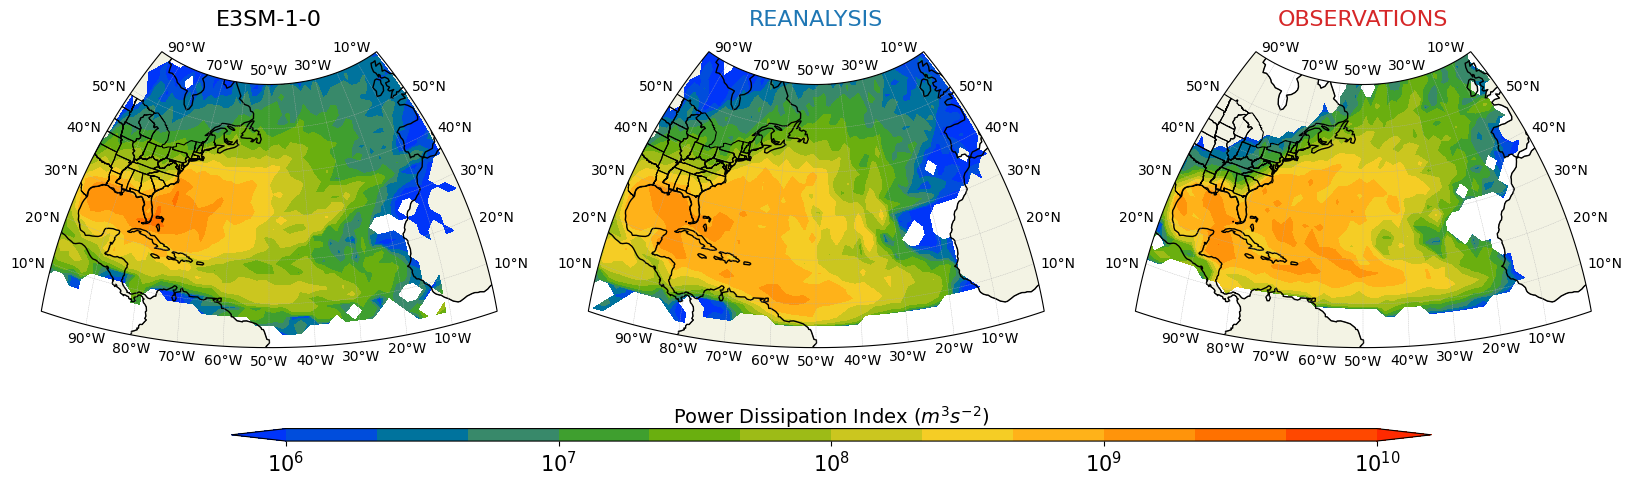

In [8]:
# Define levels and colormap
levels = np.logspace(6, 10, 13)
cmap = cc.cm.rainbow

# Create figure and axes
fig, ax = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection=projection))

# Plot MODEL density
im = tcr_plot.plot_density(
    ax[0], lat_mod_cs, lon_mod_cs, pdi_mod / num_years, levels, extent=extent, projection=projection, 
    cmap=cmap, logscale=True, gridlabel=True, shapefile=shpCONUS, title='E3SM-1-0', 
    title_ypos=1.03, title_fontcolor='k'
)

# Plot REANALYSIS density
_ = tcr_plot.plot_density(
    ax[1], lat_rea_cs, lon_rea_cs, pdi_rea / num_years, levels, extent=extent, projection=projection,
    cmap=cmap, logscale=True, gridlabel=True, shapefile=shpCONUS, title='REANALYSIS', 
    title_ypos=1.03, title_fontcolor='tab:blue'
)

# Plot OBSERVATIONS density
_ = tcr_plot.plot_density(
    ax[2], lat_obs_cs, lon_obs_cs, pdi_obs / num_years, levels, extent=extent, projection=projection,
    cmap=cmap, logscale=True, gridlabel=True, shapefile=shpCONUS, title='OBSERVATIONS',
    title_ypos=1.03, title_fontcolor='tab:red',
)

# Add colorbar
cbax = fig.add_axes([0.22, 0.0, 0.6, 0.025])
cb = fig.colorbar(im, cax=cbax, orientation='horizontal')
cb.set_label(r'Power Dissipation Index ($m^3 s^{-2}$)', fontsize=14, labelpad=-52)
cb.set_ticks(np.logspace(6, 10, 5))
cb.set_ticklabels([r'$10^{6}$', r'$10^{7}$', r'$10^{8}$', r'$10^{9}$', r'$10^{10}$'])
cb.ax.tick_params(labelsize=15)